# RNN Classifier

***Dapeng Shang, BU Questrom***

In [74]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import csv
import gzip

import matplotlib.pyplot as plt
import numpy as np

In [75]:
# Parameters
HIDDEN_SIZE = 100
BATCH_SIZE = 256
N_LAYER = 2
N_EPOCHS = 20
# N_CHARS is the size of ASCII dictionary
N_CHARS = 128
USE_GPU = False

#### 1. Preparing the data

Name $\to$ Charasters $\to$ ASCII (one-hot encoding) $\to$ Padding (creating a tensor of same size)

Country $\to$ Index


In [76]:
class NameDataset(Dataset):
    def __init__(self, is_train=True):
        # Read all the data into memory
        filename = 'names_train.csv.gz' if is_train else 'names_test.csv.gz'
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f)
            # row : (name, language)
            rows = list(reader)
        self.names = [row[0] for row in rows]
        self.len = len(self.names)
        self.countries = [row[1] for row in rows]
        # Country to Index
        self.country_list = list(sorted(set(self.countries)))
        self.country_dict = self.getCountryDict()
        self.country_num = len(self.country_list)

    def __getitem__(self, idx):
        # countries[idx] is name of country, using dict to get index
        return self.names[idx], self.country_dict[self.countries[idx]]

    def __len__(self):
        return self.len

    def getCountryDict(self):
        country_dict = dict()
        for idx, country_name in enumerate(self.country_list, 0):
            country_dict[country_name] = idx
        return country_dict

    # Helper function
    def idx2country(self, index):
        return self.country_list[index]
    
    def getCountryNum(self):
        return self.country_num

In [77]:
trainset = NameDataset(is_train=True)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testset = NameDataset(is_train=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

N_CLASSES = trainset.getCountryNum()

def create_tensor(tensor):
    if USE_GPU:
        device = torch.device('cuda:0')
        tensor = tensor.to(device)
    return tensor

#### 2. Creating the model

<div style="text-align: center">
    <img src="./Asset/p18.png" width="500" height="150">
</div>

For GRU layer:
<div style="text-align: center">
    <img src="./Asset/p19.png" width="300" height="300">
</div>

For this classifier, we only need last hidden state of the GRU layer $h_N$, as input to the fully connected layer. The output of the fully connected layer will be the output of the classifier.

In [78]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1

        # embedding layer: input: (seq_len, batch), output: (seq_len, batch, hidden_size
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        # GRU: Inputs: input: (seq_len, batch, input_size), h_0: (n_layers * n_directions, batch, hidden_size)
        # Outputs: output: (seq_len, batch, hidden_size * n_directions), h_n: (n_layers * n_directions, batch, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)

    def __init_hidden__(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size)
        return create_tensor(hidden)
    
    def forward(self, input, seq_lengths):
        # input: (batch, seq_len)
        batch_size = input.size(0)
        input = input.t() # transpose: (seq_len, batch)
        # Embedding: (seq_len, batch, hidden_size)
        embedded = self.embedding(input)
        # Initialize hidden state
        hidden = self.__init_hidden__(batch_size)
       
        # Pack it up: aviod computation on padded elements
        # PackedSequence is used to handle variable length input
        # It requires to sort the batch element by length of sequence and use length of sequence as input
        seq_lengths = seq_lengths.cpu() # it must be on CPU for torch.nn.utils.rnn.pack_padded_sequence() to work
        gru_input = torch.nn.utils.rnn.pack_padded_sequence(embedded, seq_lengths)
        _, hidden = self.gru(gru_input, hidden)
        
        # # No pack_padded_sequence
        # _, hidden = self.gru(embedded, hidden)

        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]
        return self.fc(hidden_cat)


##### What's bi-directional?

<div style="text-align: center">
    <img src="./Asset/p20.png" width="600" height="250">
</div>

Two processes are running at the same time, one is forward and the other is backward. 

Output is $[h_0, ..., h_N]$, where **$h_N = [h_N^f, h_0^b]$**.

**Hidden is $[h_N^f, h_N^b]$**, size of hidden is $n\_directions \times hidden\_size$.

#### 3. Convert name to tensor

<div style="text-align: center">
    <img src="./Asset/p21.png" width="500" height="250">
</div>

Name  $\to$ Charasters $\to$ ASCII (one-hot encoding) $\to$ Padding (batch_size, seq_len) $\to$ Transpose (seq_len, batch_size) $\to$ Sort batch by sequence length

In [79]:
def name2list(name):
    # ord: convert char to ASCII code
    arr = [ord(c) for c in name]
    return arr, len(arr)

def make_tensor(names, countries):
    # return [(name, len(name)), ...]
    array = [name2list(name) for name in names]
    name_seq = [s[0] for s in array]
    seq_lengths = torch.LongTensor([s[1] for s in array])
    countries = countries.long()

    # Pad all sequences to same length (batch_size, max_name_len)
    batch_size = len(name_seq)
    seq_tensor = torch.zeros(batch_size, seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(name_seq, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # Sort by length to use pack_padded_sequence, no need if not using it
    # .sort return (sorted_tensor, sorted_indices)
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]
    
    return create_tensor(seq_tensor), \
            create_tensor(seq_lengths), \
            create_tensor(countries)

In [80]:
# Instantiate the classifier model, N_CHARS is the size of ASCII dictionary
classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_CLASSES, N_LAYER)
if USE_GPU:
    device = torch.device('cuda:0')
    classifier.to(device)

In [81]:
classifier

RNNClassifier(
  (embedding): Embedding(128, 100)
  (gru): GRU(100, 100, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=200, out_features=18, bias=True)
)

#### 4. Criterion and Optimizer

In [82]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

#### 5. Training

In [83]:
def trainModel(epoch):
    epoch_loss = []
    for i, (names, countries) in enumerate(trainloader, 1):
        inputs, seq_lengths, target = make_tensor(names, countries)
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    print(f'Epoch {epoch}: loss = {avg_loss}')
    return avg_loss

def testModel():
    correct = 0
    total = len(testset)
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloader, 1):
            inputs, seq_lengths, target = make_tensor(names, countries)
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        percent = '%.2f' % (100 * correct / total)
        print(f'Test set: Accuracy {correct}/{total} {percent}%')

    return correct / total


In [84]:
print('Training for %d epochs...' % N_EPOCHS)
loss_list = []
acc_list = []
for epoch in range(1, N_EPOCHS + 1):
    # Train cycle
    loss =trainModel(epoch)
    acc = testModel()
    loss_list.append(loss)
    acc_list.append(acc)

Training for 20 epochs...
Epoch 1: loss = 1.5185290417581234
Test set: Accuracy 4508/6700 67.28%
Epoch 2: loss = 0.9808212215045713
Test set: Accuracy 4942/6700 73.76%
Epoch 3: loss = 0.779700073431123
Test set: Accuracy 5236/6700 78.15%
Epoch 4: loss = 0.6625556501577485
Test set: Accuracy 5364/6700 80.06%
Epoch 5: loss = 0.5806960604100857
Test set: Accuracy 5427/6700 81.00%
Epoch 6: loss = 0.5196889891939344
Test set: Accuracy 5490/6700 81.94%
Epoch 7: loss = 0.47026423575743187
Test set: Accuracy 5549/6700 82.82%
Epoch 8: loss = 0.42435285786412796
Test set: Accuracy 5575/6700 83.21%
Epoch 9: loss = 0.39313668237542204
Test set: Accuracy 5590/6700 83.43%
Epoch 10: loss = 0.3550996111249024
Test set: Accuracy 5639/6700 84.16%
Epoch 11: loss = 0.3165827475066455
Test set: Accuracy 5643/6700 84.22%
Epoch 12: loss = 0.2892655749928276
Test set: Accuracy 5652/6700 84.36%
Epoch 13: loss = 0.2582947774878088
Test set: Accuracy 5656/6700 84.42%
Epoch 14: loss = 0.22609637284053946
Test set

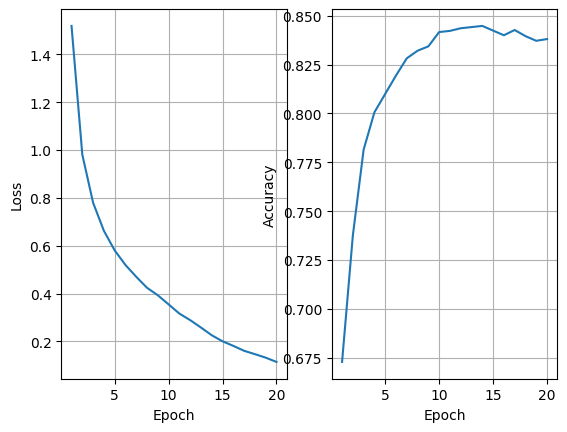

In [85]:
plt.subplot(1,2,1)
epochs = list(range(1,N_EPOCHS+1))
plt.plot(epochs,loss_list, label="Train loss")
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(epochs, acc_list, label="test accuracy")
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()